Try data analysis following the example at https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models

In [181]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import os as os
import seaborn as sns
import matplotlib.pyplot as plt

In [182]:
#fig settings
%matplotlib inline  
sns.set_style("darkgrid")

#set wd
#path='C:\\Users\\Grayson\\Documents\\Data Science\\Kaggle\\Housing'
#os.chdir(path)

In [183]:
#import data
train=pd.read_csv('train.csv')
validate=pd.read_csv('test.csv')

In [184]:
v_null_feat={el for el in validate.columns[validate.isnull().sum()>=1]}
t_null_feat={el for el in train.columns[train.isnull().sum()>=1]}
all_null_feat=v_null_feat | t_null_feat

print('Number of features with any missing values:\t {}'.format(len(all_null_feat)))
print('Total number of features:\t {}'.format(len(validate.columns)))


#For now drop all features with any missing data
#drop_feat=[feat for feat in all_null_feat]
#train=train.drop(drop_feat,axis=1)
#validate=validate.drop(drop_feat,axis=1)
#print('\nDropped columns: \t{}'.format(drop_feat))

Number of features with any missing values:	 34
Total number of features:	 80


In [185]:
print('SalePrice before adjustments:')
print("Mean:{}".format(round(train['SalePrice'].mean())) )
print("Skewness:{}".format(round(train['SalePrice'].skew(),2)) )

print('SalePrice after adjustments:')
print("Mean:{}".format(round(np.log(train['SalePrice']).mean())) )
print("Skewness:{}".format(round(np.log(train['SalePrice']).skew(),2)) )

SalePrice before adjustments:
Mean:180921
Skewness:1.88
SalePrice after adjustments:
Mean:12
Skewness:0.12


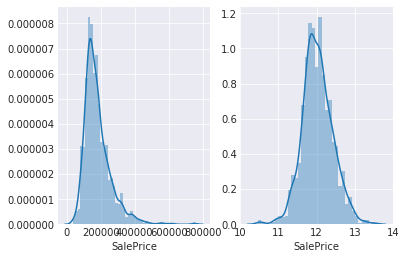

In [186]:
plt.subplot(1,2,1)
sns.distplot(train['SalePrice'])
plt.subplot(1,2,2)
sns.distplot(np.log(train['SalePrice']))
plt.show()

In [187]:
#Transform SalePrice (target)
train['SalePrice']=np.log(train['SalePrice'])
train['SalePrice'].describe()

count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64

In [188]:
#Summary of features
print({x for x in train.dtypes})
[sum(train.dtypes==y) for y in {x for x in train.dtypes}]
#38 numeric and 43 qualitative features

{dtype('int64'), dtype('O'), dtype('float64')}


[34, 43, 4]

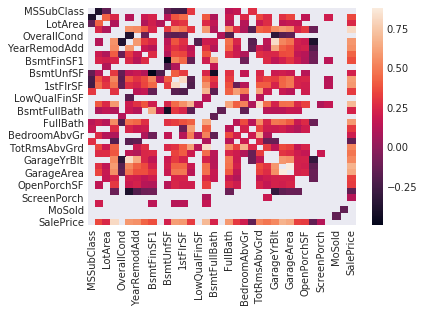

In [189]:
#look for high correlation within features
cor_mat=train.corr()
np.fill_diagonal(cor_mat.values,0)
cor_feat=train.corr()[cor_mat.abs()>0.1].dropna(axis=0,how='all').dropna(axis=1,how='all')
sns.heatmap(cor_feat)

#drop GarageCars since GarageArea is measuring the same thing
#train=train.drop(['GarageCars'],axis=1)

In [190]:
#FW

    #three cases, ~same footprint, smaller bsmt, no basement
#sns.regplot(train['TotalBsmtSF'],train['1stFlrSF'])
#plt.show()

    # Garage either built same time as house or later.  For now drop garage built but come back later
#sns.regplot(train['YearBuilt'],train['GarageYrBlt'])
#plt.show()

    #drop more columns with high correlation with existing features
#train=train.drop(['TotRmsAbvGrd','TotalBsmtSF','GarageYrBlt'],axis=1)

In [191]:
#List correlation of each variable with SalePrice
corr=train.corr()
cor_dict=corr['SalePrice'].to_dict()
cor_list=sorted(cor_dict.items(), key = lambda x: -abs(x[1]))

for el in cor_list:
    print('{0}: \t{1}'.format(el[0],el[1]))
    
#FW

#drop features with correlation below 0.2 with target
#weak_feat=[x[0] for x in cor_list if abs(x[1])<0.2]
#train=train.drop(weak_feat,axis=1)

SalePrice: 	1.0
OverallQual: 	0.8171844179216822
GrLivArea: 	0.7009266525441293
GarageCars: 	0.6806248074360439
GarageArea: 	0.6508875559020062
TotalBsmtSF: 	0.6121339753697865
1stFlrSF: 	0.596981045034374
FullBath: 	0.5947705420075314
YearBuilt: 	0.5865702403842262
YearRemodAdd: 	0.5656078325911801
GarageYrBlt: 	0.541072862595876
TotRmsAbvGrd: 	0.5344222037231195
Fireplaces: 	0.48944942759848153
MasVnrArea: 	0.43080852419510485
BsmtFinSF1: 	0.3720230735670904
LotFrontage: 	0.3558784703859834
WoodDeckSF: 	0.3341350739575136
OpenPorchSF: 	0.3210529720197666
2ndFlrSF: 	0.3192999843472038
HalfBath: 	0.3139822499151441
LotArea: 	0.25731989235273833
BsmtFullBath: 	0.2362241088243532
BsmtUnfSF: 	0.22198505352520953
BedroomAbvGr: 	0.20904368212692215
EnclosedPorch: 	-0.1490502814276759
KitchenAbvGr: 	-0.14754808847658205
ScreenPorch: 	0.12120760489686298
MSSubClass: 	-0.07395901733239706
PoolArea: 	0.06979780600969131
MoSold: 	0.05732948459791035
3SsnPorch: 	0.05490022646761992
LowQualFinSF: 

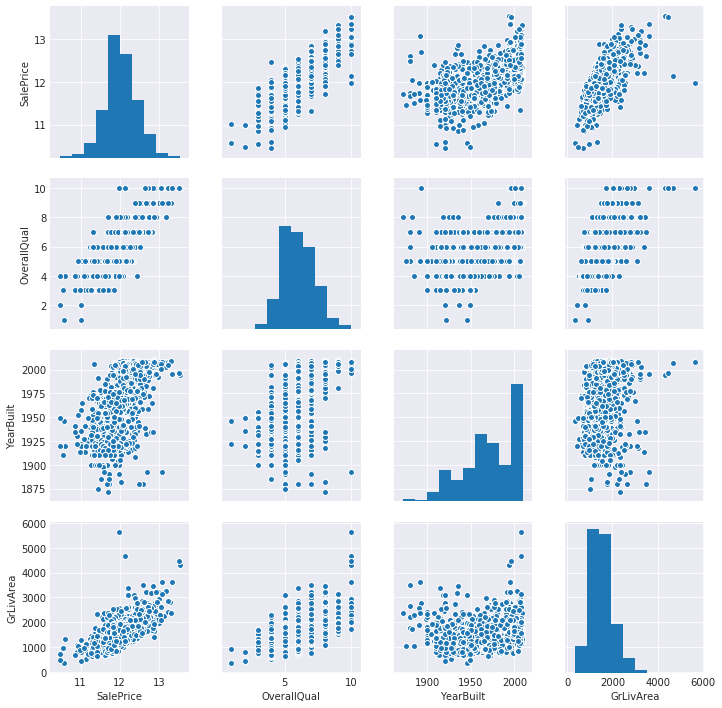

In [192]:
sns.pairplot(train.loc[:,['SalePrice','OverallQual','YearBuilt','GrLivArea']])
plt.show()

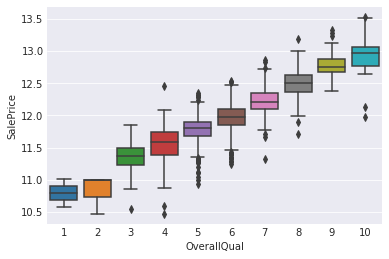

In [193]:
sns.boxplot(train['OverallQual'],train['SalePrice'])
plt.show()

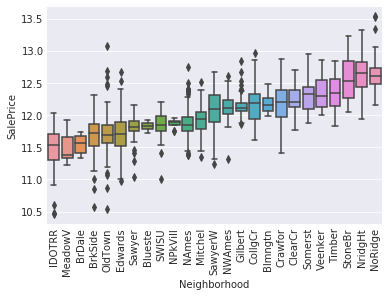

In [194]:
ordered_neighborhoods=train.groupby('Neighborhood')['SalePrice'].mean().sort_values().index
sns.boxplot(train['Neighborhood'],train['SalePrice'],order=ordered_neighborhoods)
plt.xticks(rotation=90);
plt.show()

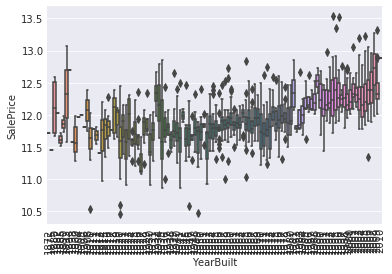

In [195]:
sns.boxplot(train['YearBuilt'],train['SalePrice'])
plt.xticks(rotation=90);
plt.show()

In [196]:
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

In [197]:
all_data=pd.concat((train.loc[:,'Id':'SaleCondition'],validate.loc[:,'Id':'SaleCondition']))

all_data=pd.get_dummies(all_data)
all_data=all_data.fillna(all_data.median())

Y=train['SalePrice']
X=all_data[:len(train)]
X_val=all_data[len(train):]

In [198]:
def RMSE(Y,P):
    SE=[(Y[i]-P[i])**2 for i in range(len(P))]
    SSE=sum(SE)
    MSE=SSE/len(P)
    RMSE=np.sqrt(MSE)
    return RMSE    

In [199]:
#split test/train for model comparison
#X_train, X_test, Y_train, Y_test =train_test_split(X, Y, test_size=0.33)

In [200]:
al=np.logspace(-5,-3,10)
lr=LassoCV(alphas=al,normalize=True)
lr.fit(X,Y)
lr_pred=lr.predict(X)
lr_pred_val=lr.predict(X_val)

In [201]:
coef_list=[(name,val) for name,val in zip(X.columns,lr.coef_) if round(val,5)>0]
coef_list=sorted(coef_list,key=lambda x: x[1],reverse=True)

for name,val in coef_list:
    print('{0}: \t {1}'.format(name,round(val,5))) 

Neighborhood_Crawfor: 	 0.0974
Neighborhood_StoneBr: 	 0.07209
OverallQual: 	 0.05993
Neighborhood_NridgHt: 	 0.04895
Exterior1st_BrkFace: 	 0.04623
KitchenQual_Ex: 	 0.04614
Functional_Typ: 	 0.04074
BsmtExposure_Gd: 	 0.03564
SaleType_New: 	 0.03277
GarageCars: 	 0.03205
OverallCond: 	 0.03177
BsmtQual_Ex: 	 0.03078
BldgType_1Fam: 	 0.02716
Condition1_Norm: 	 0.02686
LotConfig_CulDSac: 	 0.02594
Neighborhood_Somerst: 	 0.02519
Fireplaces: 	 0.02412
BsmtFullBath: 	 0.02376
Foundation_PConc: 	 0.02353
HeatingQC_Ex: 	 0.02077
Neighborhood_ClearCr: 	 0.02026
Heating_GasW: 	 0.01717
GarageCond_TA: 	 0.01349
Neighborhood_NoRidge: 	 0.01292
GarageType_Attchd: 	 0.01057
BsmtFinType1_GLQ: 	 0.00857
FireplaceQu_Gd: 	 0.00818
PavedDrive_Y: 	 0.00782
FullBath: 	 0.00761
LotShape_IR2: 	 0.00753
HalfBath: 	 0.00585
Neighborhood_Veenker: 	 0.00573
Foundation_Stone: 	 0.00411
GarageQual_Gd: 	 0.00347
Neighborhood_BrkSide: 	 0.00295
SaleType_ConLD: 	 0.00179
YearBuilt: 	 0.00144
YearRemodAdd: 	 0.000

Selected alpha: 0.0001291549665014884


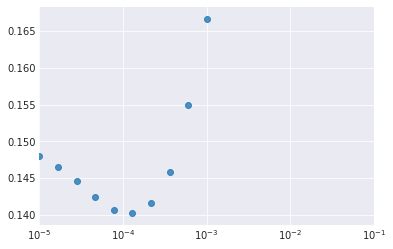

In [202]:
sns.regplot(lr.alphas_,np.sqrt(lr.mse_path_.mean(axis=1)),fit_reg=False)
ax=plt.gca()
ax.set_xscale('log')
plt.xlim(1E-5,1E-1);
print('Selected alpha: {}'.format(lr.alpha_))

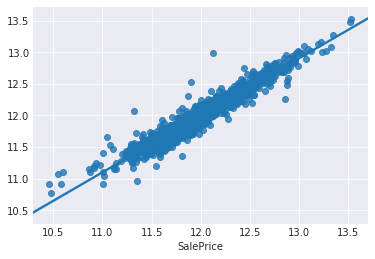

In [203]:
sns.regplot(Y,lr_pred)
plt.show()

#print('RMSE (train):\t {}'.format(RMSE(np.array(Y_train),lr_pred_train)))
#print('RMSE (test):\t {}'.format(RMSE(np.array(Y_test),lr_pred)))

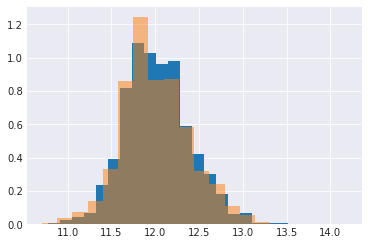

In [204]:
plt.hist(lr_pred,bins=20,normed=1);
#plt.hist(lr_pred_train,alpha=0.5,bins=20,normed=1)
plt.hist(lr_pred_val,alpha=0.5,bins=20,normed=1);

In [205]:
output = pd.DataFrame()
output['Id']=validate['Id']
output['SalePrice']=np.exp(lr_pred_val)

np.savetxt("lr_lasso.csv",output,'%1i', delimiter=",",header='Id,SalePrice',comments='')

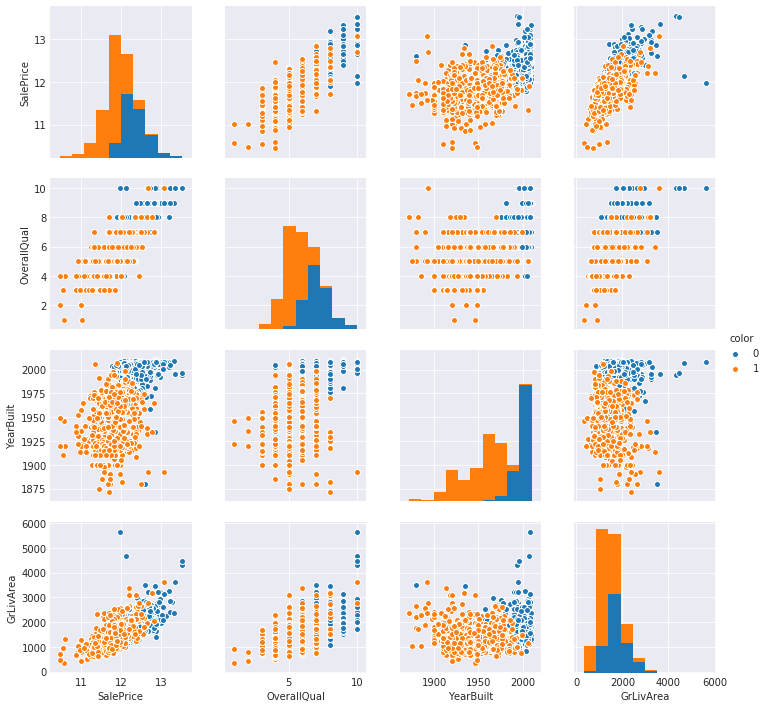

Selected alpha: 0.00021544346900318823
Selected alpha: 0.00021544346900318823


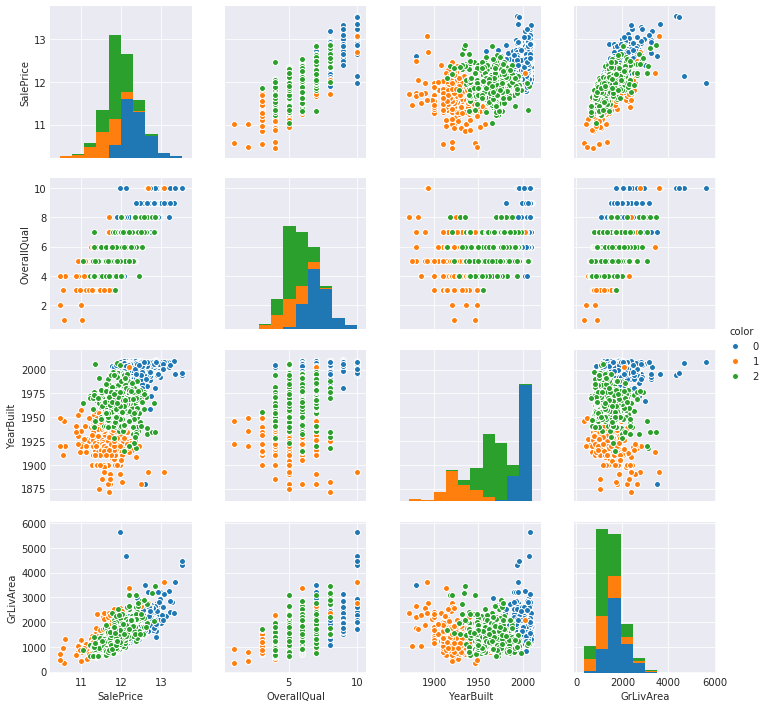

Selected alpha: 0.00021544346900318823


/home/grayson/Downloads/yes/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Selected alpha: 0.001
Selected alpha: 0.00021544346900318823


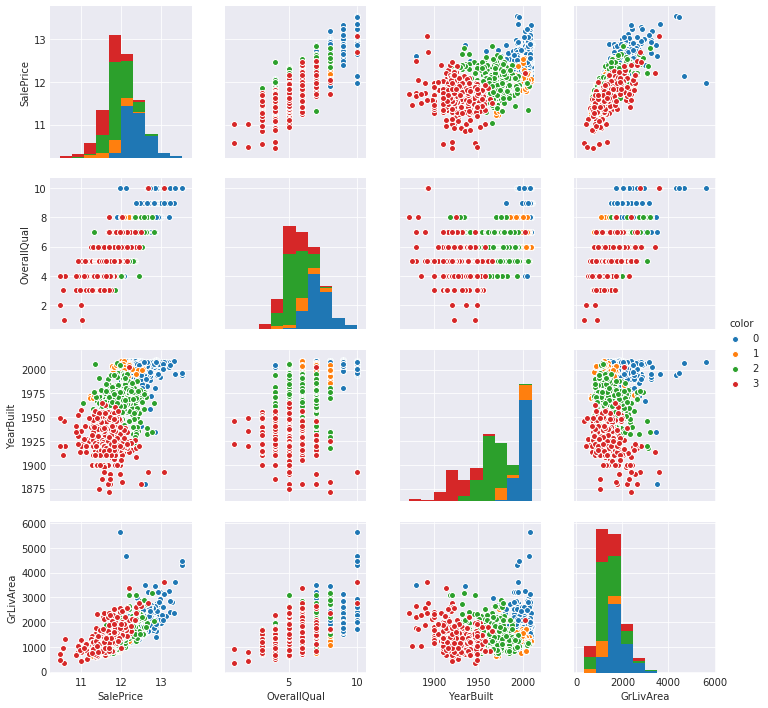

Selected alpha: 0.00046415888336127773
Selected alpha: 0.001


/home/grayson/Downloads/yes/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Selected alpha: 0.00046415888336127773


/home/grayson/Downloads/yes/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Selected alpha: 0.00046415888336127773


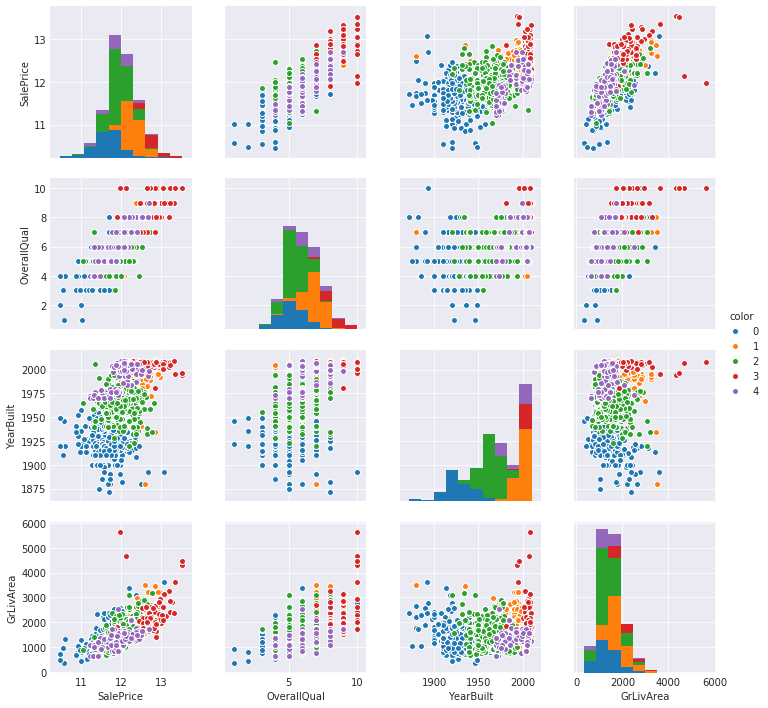

/home/grayson/Downloads/yes/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Selected alpha: 0.001


/home/grayson/Downloads/yes/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Selected alpha: 0.00021544346900318823
Selected alpha: 0.00046415888336127773


/home/grayson/Downloads/yes/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Selected alpha: 0.004641588833612777


/home/grayson/Downloads/yes/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Selected alpha: 0.00046415888336127773


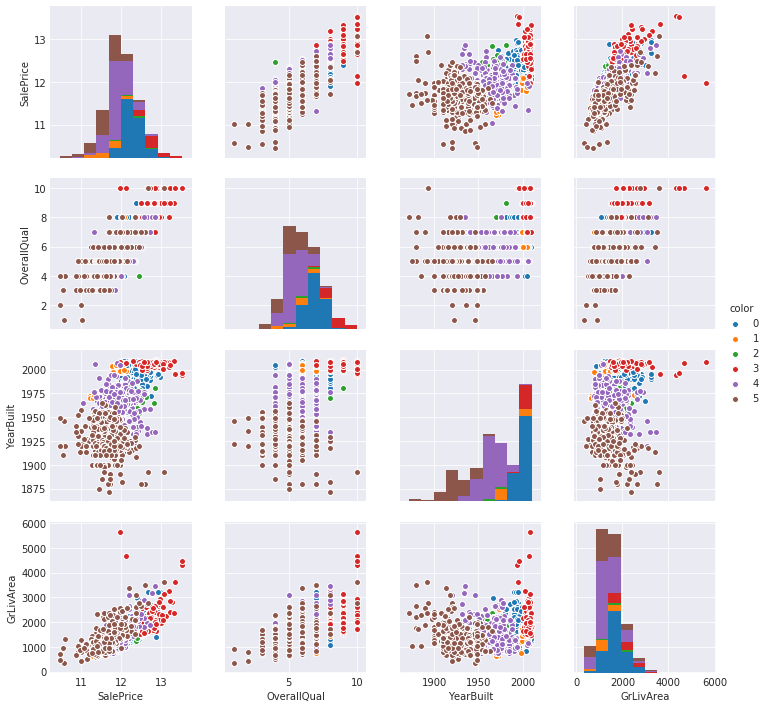

Selected alpha: 0.0001
Selected alpha: 0.002154434690031882
Selected alpha: 0.01


/home/grayson/Downloads/yes/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Selected alpha: 0.004641588833612777
Selected alpha: 0.00021544346900318823


/home/grayson/Downloads/yes/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Selected alpha: 0.001


In [206]:
output = pd.DataFrame()
output['Id']=validate['Id']

all_data_scaled=(all_data-all_data.mean())/all_data.std()

for num in [2,3,4,5,6]:
    cl=KMeans(n_clusters=num)
    cl.fit(all_data_scaled)

    train_cl_pred=cl.predict((X-all_data.mean())/all_data.std())
    val_cl_pred=cl.predict((X_val-all_data.mean())/all_data.std())
    
    plotframe=train.loc[:,:]
    plotframe['color']=train_cl_pred
    sns.pairplot(data=plotframe, vars=['SalePrice','OverallQual','YearBuilt','GrLivArea'],hue='color')
    plt.show() 

    al=np.logspace(-5,-2,10)
    lr=LassoCV(alphas=al,normalize=True)

    for i in range(num):
        lr.fit(X.loc[train_cl_pred==i],Y.loc[train_cl_pred==i])
        


        print('Selected alpha: {}'.format(lr.alpha_))
        c_pred=lr.predict(X_val.loc[val_cl_pred==i])
        output.loc[val_cl_pred==i,'SalePrice']=c_pred

    output['SalePrice']=np.exp(output['SalePrice'])
    np.savetxt("lr_lasso_{}_cluster.csv".format(num),output,'%1i', delimiter=",",header='Id,SalePrice',comments='')

In [207]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

In [237]:
pca=PCA(n_components=3)
linreg=LinearRegression()

In [244]:
pca.fit((all_data-all_data.mean())/all_data.std())
X_T=pd.DataFrame(pca.transform((X-all_data.mean())/all_data.std()))
X_val_T=pd.DataFrame(pca.transform((X_val-all_data.mean())/all_data.std()))

linreg.fit(X_T,Y)
lr_pred=linreg.predict(X_T)
lr_pred_val=linreg.predict(X_val_T)

In [272]:
p1=sorted(zip(pca.components_[0],X.columns),key=lambda x: abs(x[0]),reverse=True)

[print('{1}:\t {0}'.format(val,feat)) for val,feat in p1 if abs(val)>0.15]

YearBuilt:	 0.2000361769008851
OverallQual:	 0.18652791531108803
GarageYrBlt:	 0.1784961918903057
ExterQual_TA:	 -0.16803961729194689
Foundation_PConc:	 0.1678080886271937
YearRemodAdd:	 0.1652260623019853
GarageCars:	 0.16151924241036789
ExterQual_Gd:	 0.15189969940849732
GarageArea:	 0.15189754054012186


[None, None, None, None, None, None, None, None, None]

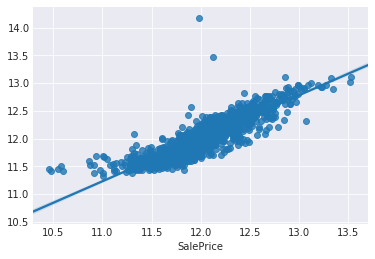

In [247]:
sns.regplot(Y,lr_pred)
plt.show()

#print('RMSE (train):\t {}'.format(RMSE(np.array(Y_train),lr_pred_train)))
#print('RMSE (test):\t {}'.format(RMSE(np.array(Y_test),lr_pred)))

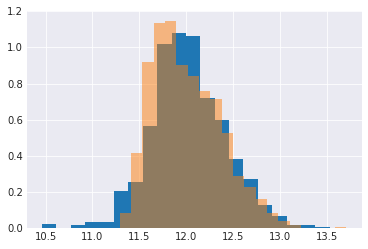

In [251]:
plt.hist(Y,bins=20,normed=1);
#plt.hist(lr_pred,alpha=0.5,bins=20,normed=1)
plt.hist(lr_pred_val,alpha=0.5,bins=20,normed=1);

In [240]:
output = pd.DataFrame()
output['Id']=validate['Id']
output['SalePrice']=np.exp(lr_pred_val)

np.savetxt("pca_lr.csv",output,'%1i', delimiter=",",header='Id,SalePrice',comments='')